In [1]:
import os 
import fitsio
import numpy as np 
from scipy.signal import medfilt
import astropy.units as u
# --- desihub --- 
import desisim.simexp
from specsim.simulator import Simulator 

from desispec.io import read_frame
from desitarget.cmx import cmx_targetmask
from desimodel.io import load_throughput

In [2]:
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
#mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

## CMX sky brightness 
First lets read sky fibers  following exposure
- tile ID = 70502
- date = 20200225
- exp ID = 52113
- spectrograph 0

In [3]:
tileid = 70502
date = 20200225
expid = 52113
ispec = 0 

dir_redux = "/global/cfs/cdirs/desi/spectro/redux/daily" 
dir_coadd = '/global/cfs/cdirs/desi/users/chahah/bgs_exp_coadd/'

In [4]:
f_sky = lambda band: os.path.join(dir_redux, 'exposures', str(date), str(expid).zfill(8), 
                                  'sky-%s%i-%s.fits' % (band, ispec, str(expid).zfill(8)))
f_calib = lambda band: os.path.join(dir_redux, 'exposures', str(date), str(expid).zfill(8), 
                                    'fluxcalib-%s%i-%s.fits' % (band, ispec, str(expid).zfill(8)))
f_frame = lambda band: os.path.join(dir_redux, 'exposures', str(date), str(expid).zfill(8), 
                                     'frame-%s%i-%s.fits' % (band, ispec, str(expid).zfill(8)))
f_cframe = lambda band: os.path.join(dir_redux, 'exposures', str(date), str(expid).zfill(8), 
                                     'cframe-%s%i-%s.fits' % (band, ispec, str(expid).zfill(8)))

wave_b = fitsio.read(f_cframe('b'), ext=3) 
wave_r = fitsio.read(f_cframe('r'), ext=3) 
wave_z = fitsio.read(f_cframe('z'), ext=3) 

sky_b = fitsio.read(f_sky('b'))
sky_r = fitsio.read(f_sky('r'))
sky_z = fitsio.read(f_sky('z'))

calib_b = fitsio.read(f_calib('b'))
calib_r = fitsio.read(f_calib('r'))
calib_z = fitsio.read(f_calib('z'))

In [5]:
# get exposure time from frame data 
frame_b = read_frame(f_frame('b'))
exptime = frame_b.meta['EXPTIME'] 
print('%.fs exposure' % exptime)

900s exposure


In [6]:
# get which are good fibers from coadd file
f_coadd = os.path.join(dir_coadd, 'coadd-%i-%i-%i-%s.fits' % (tileid, date, ispec, str(expid).zfill(8)))
coadd = fitsio.read(f_coadd)

is_good = (coadd['FIBERSTATUS'] == 0)
is_sky  = (coadd['CMX_TARGET'] & cmx_targetmask.cmx_mask.mask('SKY')) != 0 
good_sky = is_good & is_sky
print('%i good sky fibers' % np.sum(good_sky))

89 good sky fibers


David Kirkby said this overestimates the sky brightness because it includes fiberloss, but this only makes matters worse

In [7]:
sky_b_calib = sky_b[good_sky,:] * (calib_b[good_sky,:] > 0) / (calib_b[good_sky,:] + (calib_b[good_sky,:] == 0))
sky_r_calib = sky_r[good_sky,:] * (calib_r[good_sky,:] > 0) / (calib_r[good_sky,:] + (calib_r[good_sky,:] == 0))
sky_z_calib = sky_z[good_sky,:] * (calib_z[good_sky,:] > 0) / (calib_z[good_sky,:] + (calib_z[good_sky,:] == 0))

(0.0, 20.0)

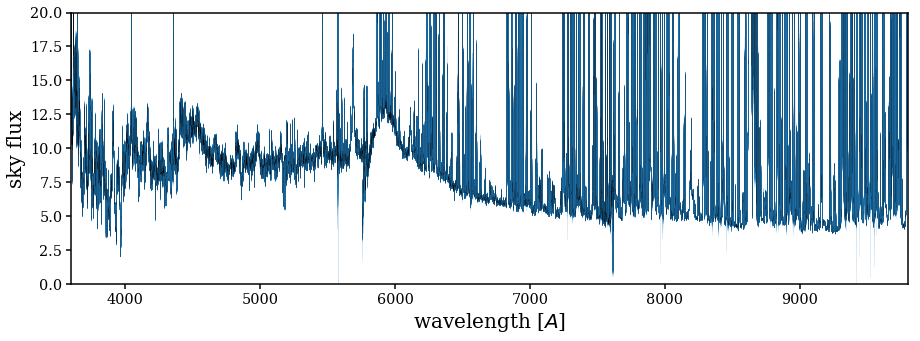

In [8]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)
for i in range(np.sum(good_sky)): 
    sub.plot(wave_b, sky_b_calib[i,:], c='C0', lw=0.1)
    sub.plot(wave_r, sky_r_calib[i,:], c='C0', lw=0.1)
    sub.plot(wave_z, sky_z_calib[i,:], c='C0', lw=0.1)
sub.plot(wave_b, np.median(sky_b_calib, axis=0), c='k', lw=0.2, ls='--')
sub.plot(wave_r, np.median(sky_r_calib, axis=0), c='k', lw=0.2, ls='--')
sub.plot(wave_z, np.median(sky_z_calib, axis=0), c='k', lw=0.2, ls='--')
sub.set_xlabel('wavelength [$A$]', fontsize=20)
sub.set_xlim(3600, 9800)
sub.set_ylabel('sky flux', fontsize=20)
sub.set_ylim(0., 20.)

Sky flux seems sensible. Now lets convert it to surfac brightness

In [9]:
desi_fiber_area = (1.46/2.)**2 * np.pi

In [10]:
sky_bright_b = sky_b_calib / desi_fiber_area
sky_bright_r = sky_r_calib / desi_fiber_area
sky_bright_z = sky_z_calib / desi_fiber_area

In [11]:
wave_sort = np.argsort(np.concatenate([wave_b, wave_r, wave_z]))

wave_sky = np.concatenate([wave_b, wave_r, wave_z])[wave_sort]
sky_calib = np.concatenate([sky_b_calib, sky_r_calib, sky_z_calib], axis=1)[:,wave_sort]
sky_bright = np.concatenate([sky_bright_b, sky_bright_r, sky_bright_z], axis=1)[:,wave_sort]

In [12]:
wavemin = load_throughput('b').wavemin - 10.0
wavemax = load_throughput('z').wavemax + 10.0
wave = np.arange(round(wavemin, 1), wavemax, 0.2) * u.Angstrom

# Generate specsim config object for a given wavelength grid
config = desisim.simexp._specsim_config_for_wave(wave.to('Angstrom').value, dwave_out=0.8, specsim_config_file='desi')
nominal_surface_brightness_dict = config.load_table(config.atmosphere.sky, 'surface_brightness', as_dict=True)

(0.0, 20.0)

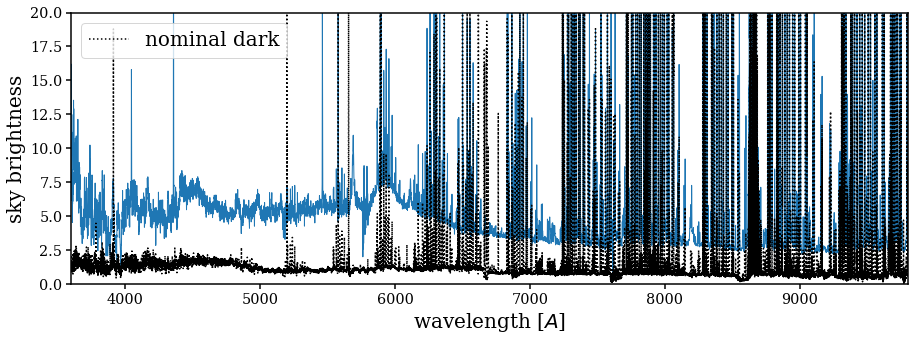

In [13]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)

sub.plot(wave_sky, np.median(sky_bright, axis=0), c='C0', lw=1) 
    
sub.plot(wave.value, nominal_surface_brightness_dict['dark'].value, c='k', ls=':', label='nominal dark')

sub.legend(loc='upper left', frameon=True, fontsize=20)
sub.set_xlabel('wavelength [$A$]', fontsize=20)
sub.set_xlim(3600, 9800)
sub.set_ylabel('sky brightness', fontsize=20)
sub.set_ylim(0., 20.)

## CMX spectra
lets read in spectra for a bright $r \sim 16.5$ BGS galaxy

In [14]:
# directory with coadds constructed from single exposure cframe data 
dir_coadd = '/global/cfs/cdirs/desi/users/chahah/bgs_exp_coadd/'

In [15]:
fcoadd = os.path.join(dir_coadd, 'coadd-%i-%i-%i-%s.fits' % (tileid, date, ispec, str(expid).zfill(8)))

In [16]:
coadd = fitsio.read(fcoadd)
coadd_wave = fitsio.read(fcoadd, ext=2)
coadd_flux = fitsio.read(fcoadd, ext=3)
coadd_ivar = fitsio.read(fcoadd, ext=4)

In [17]:
is_BGS  = (coadd['CMX_TARGET'] & cmx_targetmask.cmx_mask.mask('SV0_BGS')) != 0 
print('%i BGS targets' % np.sum(is_BGS))

288 BGS targets


In [18]:
coadd_rmag =  22.5 - 2.5 * np.log10(coadd['FLUX_R']) 
coadd_gmag =  22.5 - 2.5 * np.log10(coadd['FLUX_G']) 

/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app


In [19]:
gal_cut = is_BGS & (coadd_rmag > 16.4) & (coadd_rmag < 16.6) & (np.sum(coadd_flux, axis=1) != 0)
igal = np.random.choice(np.arange(len(gal_cut))[gal_cut])

(0.0, 40.0)

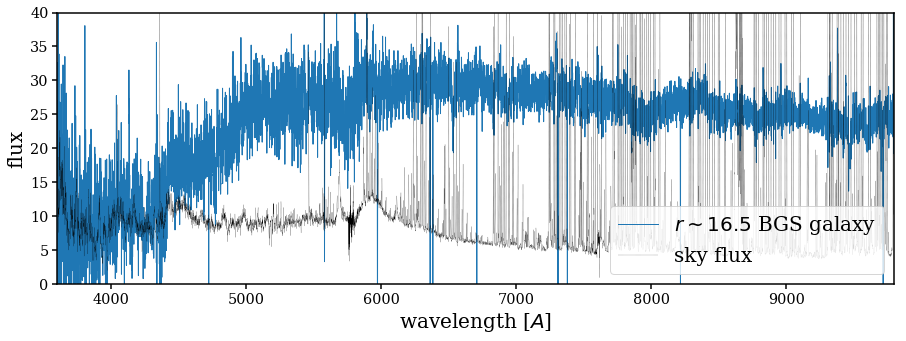

In [32]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)

sub.plot(coadd_wave, coadd_flux[igal,:], c='C0', lw=1, label='$r\sim16.5$ BGS galaxy')

sub.plot(wave_sky, np.median(sky_calib, axis=0), c='k', lw=0.2, ls='--', label='sky flux')

sub.legend(loc='lower right', frameon=True, fontsize=20)
sub.set_xlabel('wavelength [$A$]', fontsize=20)
sub.set_xlim(3600, 9800)
sub.set_ylabel('flux', fontsize=20)
sub.set_ylim(0., 40.)

## comparison to `specsim`
The spectra seems very noisy... Now lets compare this spectra to the output of `specsim` where we use the smoothed out noiseless spectra as the source flux and the actual sky surface brightness. 

In [21]:
desi = Simulator(config, num_fibers=1)

In [22]:
coadd_flux_smooth = np.interp(wave, coadd_wave, medfilt(coadd_flux[igal,:], 101)) * 1e-17 * desi.simulated['source_flux'].unit

(0.0, 40.0)

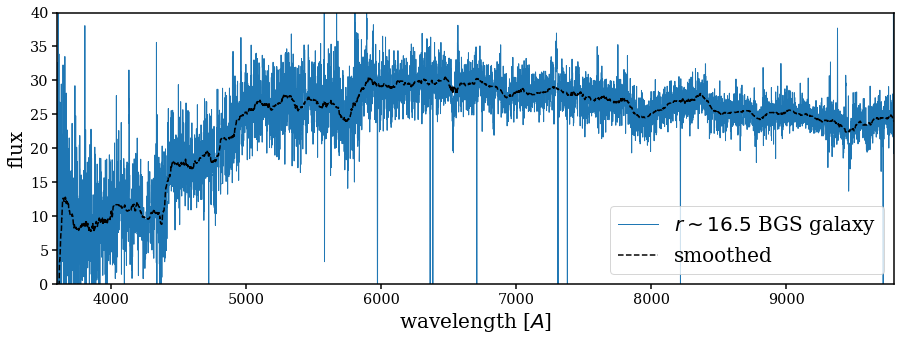

In [30]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)

sub.plot(coadd_wave, coadd_flux[igal,:], c='C0', lw=1, label='$r\sim16.5$ BGS galaxy')
sub.plot(wave, coadd_flux_smooth.value * 1e17, c='k', ls='--', label='smoothed')

sub.legend(loc='lower right', frameon=True, fontsize=20)
sub.set_xlabel('wavelength [$A$]', fontsize=20)
sub.set_xlim(3600, 9800)
sub.set_ylabel('flux', fontsize=20)
sub.set_ylim(0., 40.)

In [24]:
# initialize the exposure time
desi.observation.exposure_time = exptime * u.s
print('%.fs exposure' % desi.observation.exposure_time.to(u.s).value) 

900s exposure


In [25]:
# manually set the surface brightness 
desi.atmosphere._surface_brightness_dict[desi.atmosphere.condition] = np.interp(desi.atmosphere._wavelength, wave_sky, np.median(sky_bright, axis=0)) * desi.atmosphere.surface_brightness.unit
desi.atmosphere._extinct_emission = False
desi.atmosphere._moon = None 
desi.atmosphere.airmass = 2. # high airmass 

In [26]:
desi.simulate(source_fluxes=np.atleast_2d(coadd_flux_smooth), fiber_acceptance_fraction=np.ones_like(np.atleast_2d(coadd_flux_smooth)))

In [27]:
random_state = np.random.RandomState(0)
desi.generate_random_noise(random_state, use_poisson=True)

scale=1e17

waves, fluxes, ivars = [], [], []
for table in desi.camera_output :
    print('---------------') 
    print(' wave    ', np.array(table['wavelength'].astype(float)).flatten())
    print(' source  ', np.array(table['num_source_electrons']).flatten())
    print(' sky     ', np.array(table['num_sky_electrons']).flatten())
    print(' dark    ', np.array(table['num_dark_electrons']).flatten())
    print(' read    ', np.array(table['read_noise_electrons']).flatten())

    _wave = table['wavelength'].astype(float)
    _flux = (table['observed_flux']+table['random_noise_electrons']*table['flux_calibration']).T.astype(float)
    _flux = _flux * scale

    _ivar = table['flux_inverse_variance'].T.astype(float)
    _ivar = _ivar / scale**2 

    waves.append(_wave)
    fluxes.append(_flux[0]) 
    ivars.append(_ivar[0])

---------------
 wave     [3569.3 3570.1 3570.9 ... 5946.9 5947.7 5948.5]
 source   [ 0.          0.          0.         ... 22.71749374 22.73610063
 22.5487586 ]
 sky      [172.68193311 173.25282498 173.82973879 ...  17.55091717  18.84065171
  18.05626222]
 dark     [2.39065347 2.39009108 2.38954445 ... 2.67056344 2.6709579  2.67134342]
 read     [7.45637414 7.45549705 7.45464443 ... 7.88080944 7.88139145 7.88196021]
---------------
 wave     [5625.3 5626.1 5626.9 ... 7738.9 7739.7 7740.5]
 source   [ 4.56513394  4.72834641  4.88711786 ... 67.10519557 66.1932075
 65.41844973]
 sky      [ 3.08502201  3.08285499  2.85819678 ... 27.99852086 22.13883489
 19.57612623]
 dark     [3.18057435 3.17957331 3.17860504 ... 3.77306565 3.77388011 3.77468067]
 read     [5.98619002 5.98524792 5.98433651 ... 6.51995959 6.52066325 6.52135483]
---------------
 wave     [7435.3 7436.1 7436.9 ... 9832.1 9832.9 9833.7]
 source   [44.94146537 46.36449988 47.79785319 ...  0.          0.
  0.        ]
 sky    

(0.0, 40.0)

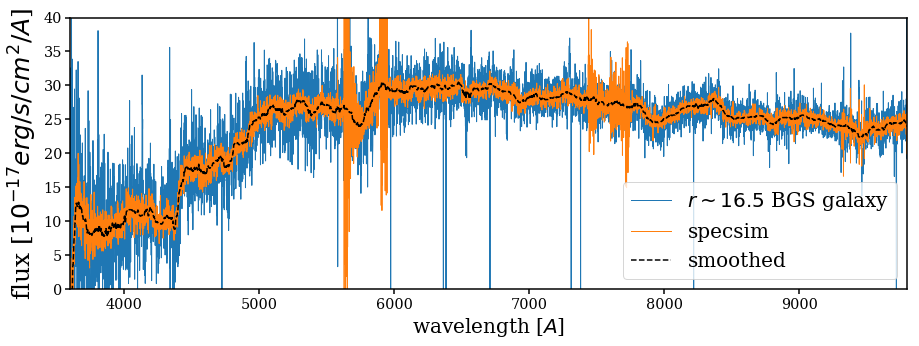

In [31]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)

sub.plot(coadd_wave, coadd_flux[igal,:], c='C0', lw=1, label='$r\sim16.5$ BGS galaxy')
for lbl, _wave, _flux in zip([None, None, 'specsim'], waves, fluxes):
    sub.plot(_wave, _flux, c='C1', lw=1, label=lbl)
sub.plot(wave, coadd_flux_smooth.value * 1e17, c='k', ls='--', label='smoothed')


sub.legend(loc='lower right', frameon=True, fontsize=20)
sub.set_xlabel('wavelength [$A$]', fontsize=20)
sub.set_xlim(3600, 9800)
sub.set_ylabel('flux [$10^{-17} erg/s/cm^2/A$]', fontsize=25) 
sub.set_ylim(0., 40.)

Text(0,0.5,'ivar')

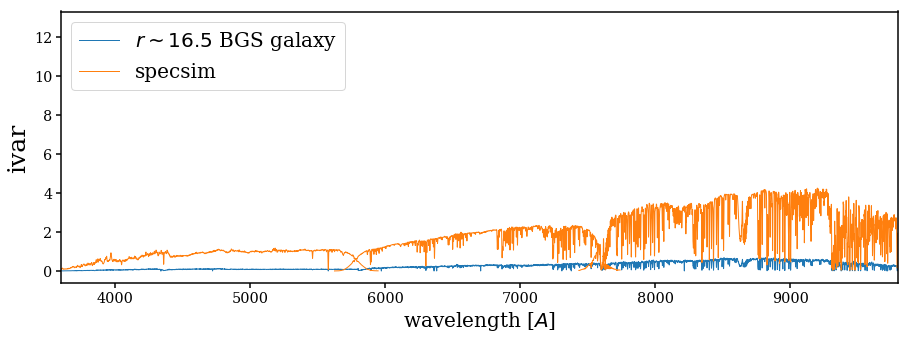

In [29]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)

sub.plot(coadd_wave, coadd_ivar[igal,:], c='C0', lw=1, label='$r\sim16.5$ BGS galaxy')
for lbl, _wave, _ivar in zip([None, None, 'specsim'], waves, ivars):
    sub.plot(_wave, _ivar, c='C1', lw=1, label=lbl)

sub.legend(loc='upper left', frameon=True, fontsize=20)
sub.set_xlabel('wavelength [$A$]', fontsize=20)
sub.set_xlim(3600, 9800)
sub.set_ylabel('ivar', fontsize=25) 
#sub.set_ylim(0., 30.)